# インポート

In [3]:
import pandas as pd
from pathlib import Path

COMMON_DATA_DIR = Path("..", "..", "common", "data")
RAWDF_DIR = COMMON_DATA_DIR / "rawdf"

# データ加工

## レース結果テーブルの加工

In [4]:
# レース結果のCSVを読み込み
df = pd.read_csv(RAWDF_DIR / "results.csv", sep="\t")

In [34]:
# すべて表示すると見にくいため、表示するデータを絞る
# iloc[行, 列]で指定できる。「:」はすべてを表す。
# よって次の記述はcsvの全行かつ先頭から10列分を表示。
df.iloc[:, 0:10]

,race_id,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差
0,202408060405,1,8,10,エコロディノス,牡2,56.0,ムーア,2:00.9,NaN
1,202408060405,2,5,5,トロワヴァレー,牡2,56.0,Ｃ．デム,2:01.5,3.1/2
2,202408060405,3,1,1,コジオスコ,牡2,56.0,ルメール,2:01.9,2.1/2
3,202408060405,4,7,8,アロマフェリス,牝2,55.0,鮫島克駿,2:02.4,3
4,202408060405,5,8,9,サウスオブロンドン,牡2,55.0,泉谷楓真,2:02.7,2
...,...,...,...,...,...,...,...,...,...,...
46544,202405010107,12,3,5,グランヒマラヤ,牡4,57.0,石橋脩,1:29.1,2.1/2
46545,202405010107,13,4,8,フエキ,牝5,56.0,嶋田純次,1:29.2,クビ
46546,202405010107,14,6,12,ジャーニーメモリー,牡4,56.0,原優介,1:29.2,クビ
46547,202405010107,15,8,15,テンプーシャオン,牡4,57.0,大野拓弥,1:30.4,7


In [8]:
# 着順列を取得
df["着順"]

0         1
1         2
2         3
3         4
4         5
         ..
46544    12
46545    13
46546    14
46547    15
46548    16
Name: 着順, Length: 46549, dtype: object

In [9]:
# 着順列のdtypeがobjectになっている
# 機械学習モデルに入れるにはobjectだと入れられないため
# 数値型に変換する
df["着順"].astype(int)

ValueError: invalid literal for int() with base 10: '中'

In [ ]:
# エラーになったのは着順列に、中止を表す「中」が含まれているためint変換できない
# 数値でない値は省く
# pandasのto_numericを使えば、エラー時の動きを指定できる
# デフォルトはraiseでエラーを返す、coerceを指定すればエラーになるものは欠損値に変換する
pd.to_numeric(df["着順"], errors="coerce")

0         1.0
1         2.0
2         3.0
3         4.0
4         5.0
         ... 
46544    12.0
46545    13.0
46546    14.0
46547    15.0
46548    16.0
Name: 着順, Length: 46549, dtype: float64

In [11]:
# 欠損値がどれくらいあるのか調べたい
df["rank"] = pd.to_numeric(df["着順"], errors="coerce")
# value_countsはデフォルトでは欠損値が省かれるため、dropna=Falseを指定する
df["rank"].value_counts(dropna=False)

rank
1.0     3409
3.0     3405
2.0     3404
4.0     3404
5.0     3399
6.0     3395
7.0     3375
8.0     3285
9.0     3177
10.0    3009
11.0    2785
12.0    2520
13.0    2246
14.0    1991
15.0    1625
16.0    1203
NaN      422
17.0     292
18.0     203
Name: count, dtype: int64

In [13]:
# 目的変数でrankを求める際に、NaNのデータは不要なので省いてあげる
# rankの中から欠損値を省く処理、inplace=Trueはdf自体に変更を加える
df.dropna(subset=["rank"], inplace=True)

In [14]:
df["rank"].value_counts(dropna=False)

rank
1.0     3409
3.0     3405
2.0     3404
4.0     3404
5.0     3399
6.0     3395
7.0     3375
8.0     3285
9.0     3177
10.0    3009
11.0    2785
12.0    2520
13.0    2246
14.0    1991
15.0    1625
16.0    1203
17.0     292
18.0     203
Name: count, dtype: int64

In [15]:
# 枠番、馬番
df["枠番"].astype(int)

0        8
1        5
2        1
3        7
4        8
        ..
46544    3
46545    4
46546    6
46547    8
46548    2
Name: 枠番, Length: 46127, dtype: int64

In [ ]:
# 性齢は、性別と年齢がくっついているので分けてあげる
df["性齢"]

0        牡2
1        牡2
2        牡2
3        牝2
4        牡2
         ..
46544    牡4
46545    牝5
46546    牡4
46547    牡4
46548    牡6
Name: 性齢, Length: 46127, dtype: object

In [5]:
# .str[0]で１文字を取得
df["性齢"].str[0].value_counts()

性齢
牡    25084
牝    19300
セ     2165
Name: count, dtype: int64

ラベルエンコーディング：カテゴリ変数を整数にマッピングするデータ加工手法

In [7]:
# 性別が文字なので数値にする必要がある
# ラベルエンコーディングという手法を使う
sex_mapping = {"牡": 0, "牝": 1, "セ": 2}

In [9]:
# mapでマッピングできる
df["性齢"].str[0].map(sex_mapping).value_counts()

性齢
0    25084
1    19300
2     2165
Name: count, dtype: int64

In [26]:
# 次は年齢を取り出す
df["性齢"].str[1:].astype(int)

0        2
1        2
2        2
3        2
4        2
        ..
46544    4
46545    5
46546    4
46547    4
46548    6
Name: 性齢, Length: 46127, dtype: int64

In [ ]:
# 斤量はもともと数値型なので大丈夫
df["斤量"]

0        56.0
1        56.0
2        56.0
3        55.0
4        55.0
         ... 
46544    57.0
46545    56.0
46546    56.0
46547    57.0
46548    58.0
Name: 斤量, Length: 46127, dtype: float64

In [32]:
# 次は10〜20列目
df.iloc[:, 10:20]

,単勝,人気,馬体重,調教師,horse_id,jockey_id,trainer_id,owner_id,rank
0,2.3,1.0,472(0),[西] 大久保龍,2022105073,5366,1058,783033,1.0
1,3.9,2.0,470(0),[西] 吉岡辰弥,2022105169,5473,1176,486800,2.0
2,5.3,3.0,494(0),[西] 武幸四郎,2022105091,5339,1160,133803,3.0
3,30.2,7.0,408(0),[西] 辻野泰之,2022104624,1157,1183,486800,4.0
4,107.7,9.0,478(0),[西] 松永幹夫,2022102413,1182,1092,208008,5.0
...,...,...,...,...,...,...,...,...,...
46544,6.7,3.0,504(+10),[東] 松山将樹,2020100847,1077,1100,661030,12.0
46545,14.1,7.0,524(+10),[東] 和田正一,2019102479,1134,1114,251800,13.0
46546,63.2,14.0,468(+10),[東] 粕谷昌央,2020104437,1184,1096,457002,14.0
46547,51.7,13.0,450(+16),[東] 和田勇介,2020102767,1096,1165,634033,15.0


In [36]:
df["単勝"].astype(float)

0          2.3
1          3.9
2          5.3
3         30.2
4        107.7
         ...  
46544      6.7
46545     14.1
46546     63.2
46547     51.7
46548     27.7
Name: 単勝, Length: 46127, dtype: float64

In [38]:
df["人気"].astype(int)

0         1
1         2
2         3
3         7
4         9
         ..
46544     3
46545     7
46546    14
46547    13
46548     9
Name: 人気, Length: 46127, dtype: int64

In [43]:
df["馬体重"]

0          472(0)
1          470(0)
2          494(0)
3          408(0)
4          478(0)
           ...   
46544    504(+10)
46545    524(+10)
46546    468(+10)
46547    450(+16)
46548     478(+6)
Name: 馬体重, Length: 46127, dtype: object

In [44]:
# extract（正規表現）で体重部分を抜き出す。
# \d+で数字の繰り返し部分のみ取り出す
df["weight"] = df["馬体重"].str.extract(r"(\d+)").astype(int)
df["weight"]

0        472
1        470
2        494
3        408
4        478
        ... 
46544    504
46545    524
46546    468
46547    450
46548    478
Name: weight, Length: 46127, dtype: int64

In [48]:
# 体重の増減を抜き出す
# ()の前に\でエスケープさせて、取り出したい文字列は「(.+)」としている
# .+で任意の文字列なので、()で囲われた任意の文字列が対象となる
df["weight_diff"] = df["馬体重"].str.extract(r"\((.+)\)").astype(int)
df["weight_diff"]

0         0
1         0
2         0
3         0
4         0
         ..
46544    10
46545    10
46546    10
46547    16
46548     6
Name: weight_diff, Length: 46127, dtype: int64

ここまでで、使いたい情報を加工できたので、preprocessing.pyに関数化する

In [17]:
df = pd.read_csv(RAWDF_DIR / "horse_results.csv", sep="\t")

# horse_results中の「天気」列や「馬場」列などは、数値データではなく
# 「その行が特定のカテゴリに属する」ことを表す「カテゴリ変数」
# カテゴリ変数の処理によく「ダミー変数化」が利用されるらしいが、デメリットがあるため
# ラベルエンコーディングを行う（各カテゴリに対して一意の整数値を割り当てること）
weather_mapping = {'小雨': 0, '晴': 1, '曇': 2, '雨': 3, '小雪': 4, '雪': 5}
df["天気"].map(weather_mapping)

0         2.0
1         1.0
2         1.0
3         2.0
4         1.0
         ... 
146439    1.0
146440    2.0
146441    1.0
146442    2.0
146443    2.0
Name: 天気, Length: 146444, dtype: float64

In [ ]:
# 競馬予想AI作成の肝は「相対評価をどうするか」にある
# 着順を相対的に判断するため、一緒に走った馬がどの程度強かったかが
# 重要な情報になる
# レースを階級で判断してみる
df["レース名"]

0           3歳未勝利
1           3歳未勝利
2           2歳未勝利
3            2歳新馬
4         凧あげ賞(B)
           ...   
146439       2歳新馬
146440     3歳ー15組
146441     3歳ー12組
146442      3歳未勝利
146443       2歳新馬
Name: レース名, Length: 146444, dtype: object

In [19]:
import json

MAPPING_DIR = COMMON_DATA_DIR / "mapping"

with open(MAPPING_DIR / "race_class.json", "r") as f:
    race_class_mapping = json.load(f)

In [22]:
# レース名には"３歳以上１勝クラス"のように、他の文字列がついている
# まずは「レース名」列からrace_class_mappingに含まれる文字列のみ取り出す
regex_race_class = "|".join(race_class_mapping)
regex_race_class

'新馬|未勝利|1勝クラス|2勝クラス|3勝クラス|オープン|G3|G2|G1|特別|500万下|1000万下|1600万下|OP'

In [ ]:
# .str.extracr()を行うことで、正規表現で「"新馬"または"未勝利"または..を取り出す」という処理になる
df["race_class"] = df["レース名"].str.extract(rf"({regex_race_class})")
df["race_class"]

0         未勝利
1         未勝利
2         未勝利
3          新馬
4         NaN
         ... 
146439     新馬
146440    NaN
146441    NaN
146442    未勝利
146443     新馬
Name: race_class, Length: 146444, dtype: object

## 馬の過去成績集計

まずは「馬の過去成績テーブル」から直近nレースの着順や賞金の平均を集計し<br>
「レース結果テーブル」に紐づける<br>
<br>
単純にするなら「レース結果テーブル」と「馬の過去成績テーブル」を<br>
horse_idで紐づけ、新しい成績からnレース分集計すれば良いと思う。<br>
ただし、上の紐付け方には問題がある。<br>
馬の過去成績テーブルは「レース結果テーブルの出走日以前の成績」に絞らなければならない。<br>
<br>
例えば、出走日が2024年1月1日のレース結果に紐付ける場合<br>
それより過去のデータに絞って「直近nレースの着順や賞金の平均」を集計する必要あり<br>
なぜなら、2024年の全レース結果を取得してきているので「それより後の馬の過去成績」が<br>
取得できてしまい、本来は2024年1月1日時点では存在しないデータとなる。<br>
<br>
本来取得できないデータを予測材料に使ってしまうことを、機械学習の用語で「リーク」という。<br>
正解がわかっている状態なので予測にならず学習にもならない<br>
やけに精度が高い場合はリークを疑う

In [ ]:
# 出走日でデータを抽出したいため、出走日を取得する
# keiba.comのレース情報は非構造化データになっているため
# 工夫してDataFrameとして保存する


## 機械学習モデルの作成

In [1]:
# まずは作成した特徴量を読み込む
import pandas as pd
from pathlib import Path

INPUT_DIR = Path("..", "data", "02_features")
features = pd.read_csv(INPUT_DIR / "features.csv", sep="\t")

In [2]:
# 機械学習では何を「学習」させるのか、簡潔に言うと「目的変数と説明変数の対応関係」を学習させる
# 目的変数：rank列（を、「1着かどうか」の0or1データにしたもの）
# 説明変数：以下のfeature_cols列
feature_cols = [
    'horse_id',
    'jockey_id',
    'trainer_id',
    'umaban',
    'wakuban',
    'tansho_odds',
    'popularity',
    'impost',
    'sex',
    'age',
    'weight',
    'weight_diff',
    'race_type',
    'around',
    'course_len',
    'weather',
    'ground_state',
    'race_class',
    'place',
    'rank_3races',
    'prize_3races',
    'rank_5races',
    'prize_5races',
    'rank_10races',
    'prize_10races',
    'rank_1000races',
    'prize_1000races'
]

In [3]:
# この対応関係を学習させることで、「説明変数をインプットすると、目的変数を予測する」
# 機械学習モデルが完成する仕組み。
# 今回は単勝予測モデルを作成するので、「1着なら1,そうでないなら0」というデータをもった
# target列を作成する。
features["target"] = (features["rank"] == 1).astype(int)

In [4]:
# 学習させる際は、データを学習データと検証（テスト）データに分け、
# 学習データのみを学習させる。
# こうすることで「未知のデータがやってきた時の精度がどれくらいなのか」を
# 検証データで検証できる。
# また、この時必ず学習データは検証データより時系列的に過去のデータを使うこともポイント。
train_df = features.query("date < '2024-10-01'")
test_df = features.query("date >= '2024-10-01'")

In [ ]:
#pip install lightgbm

In [5]:
# データが分割できたら、LightGBMに学習させる
import lightgbm as lgb

# データセットの作成
lgb_train = lgb.Dataset(
    train_df[feature_cols], train_df["target"]
)
lgb_test = lgb.Dataset(
    test_df[feature_cols], test_df["target"]
)
# パラメータの設定
params = {
    "objective": "binary",  # 二値分類
    "metric": "binary_logloss", # 予測誤差
    "random_state": 100,    # 実行ごとに同じ結果を得るための設定
}
# 学習の実行
model = lgb.train(
    params=params,
    train_set=lgb_train,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[lgb.log_evaluation()],
)

[LightGBM] [Info] Number of positive: 2593, number of negative: 32457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2921
[LightGBM] [Info] Number of data points in the train set: 35050, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073980 -> initscore=-2.527101
[LightGBM] [Info] Start training from score -2.527101
[1]	training's binary_logloss: 0.247522	valid_1's binary_logloss: 0.248105
[2]	training's binary_logloss: 0.237734	valid_1's binary_logloss: 0.239944
[3]	training's binary_logloss: 0.23037	valid_1's binary_logloss: 0.233582
[4]	training's binary_logloss: 0.2245	valid_1's binary_logloss: 0.228711
[5]	training's binary_logloss: 0.219672	valid_1's binary_logloss: 0.224621
[6]	training's binary_logloss: 0.215554	valid_1's binary_logloss: 0.221

In [6]:
# テストデータに対して予測をしてみる
model.predict(test_df[feature_cols])

array([0.00854581, 0.00655834, 0.00450167, ..., 0.00592743, 0.07620167,
       0.09146778])

In [7]:
# 上記を使って、検証用DataFrameを作成する
evaluation_df = test_df[
    [
        "race_id",
        "horse_id",
        "target",
        "rank",
        "tansho_odds",
        "popularity",
    ]
].copy()
evaluation_df["pred"] = model.predict(test_df[feature_cols])

In [8]:
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
6149,202403030101,2022104140,0,9,47.2,9,0.008546
6150,202403030101,2022101893,0,15,167.6,12,0.006558
6151,202403030101,2022104708,0,12,168.6,13,0.004502
6152,202403030101,2022106567,0,6,9.2,5,0.073428
6153,202403030101,2022103703,0,2,6.0,2,0.160950
...,...,...,...,...,...,...,...
39760,202408070912,2021100130,1,1,1.9,1,0.377480
39761,202408070912,2020110133,0,11,43.1,10,0.016322
39762,202408070912,2019102786,0,3,105.4,14,0.005927
39763,202408070912,2021102888,0,7,10.6,5,0.076202


In [9]:
# 各レース、predの値が一番高いものに単勝馬券で賭ける場合を考える
bet_df = (
    evaluation_df
    .sort_values("pred", ascending=False)
    .groupby("race_id")
    .head(1)
)

In [10]:
bet_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
36828,202408050609,2021106449,1,1,1.4,1,0.896121
17344,202405040709,2021104844,1,1,1.4,1,0.848708
17292,202405040705,2022104635,0,4,1.4,1,0.825920
11053,202404040503,2022102819,1,1,1.3,1,0.822293
30277,202407040605,2022104732,0,2,1.3,1,0.812081
...,...,...,...,...,...,...,...
11269,202404040610,2021106307,0,13,4.1,1,0.137193
18122,202405050411,2020103063,0,3,7.3,4,0.132217
38536,202408070207,2021102754,0,5,3.9,1,0.127382
6384,202403030207,2018102170,0,12,4.2,1,0.126503


In [11]:
# 的中率
bet_df["target"].mean()

np.float64(0.3374233128834356)

In [12]:
# 回収率
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
cost = len(bet_df)
return_ / cost

np.float64(0.8505521472392639)

In [13]:
# 回収率が85%となったので、これを１番人気に賭け続けた場合と比較してみる
bet_df = (
    evaluation_df
    .sort_values("popularity")
    .groupby("race_id")
    .head(1)
)
# 的中率
bet_df["target"].mean()

np.float64(0.3619631901840491)

In [14]:
# 回収率
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
cost = len(bet_df)
return_ / cost

np.float64(0.8796319018404909)

In [15]:
# 今回の機械学習モデルは的中率も回収率も１番人気に賭け続けたモデルに負けていることになる。
# また、機械学習で１着と判定された馬と一番人気が食い違っているデータに絞って
# 的中率・回収率を見てみる

# 一番人気とモデルの一着判定が違う馬
bet_df = (
    evaluation_df
    .sort_values("pred", ascending=False)
    .groupby("race_id")
    .head(1)
    .query("popularity != 1")
)

In [16]:
# 的中率
bet_df["target"].mean()

np.float64(0.18518518518518517)

In [17]:
# 回収率
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
cost = len(bet_df)
return_ / cost

np.float64(0.7697530864197532)

In [ ]:
#pip install matplotlib

Matplotlib is building the font cache; this may take a moment.


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

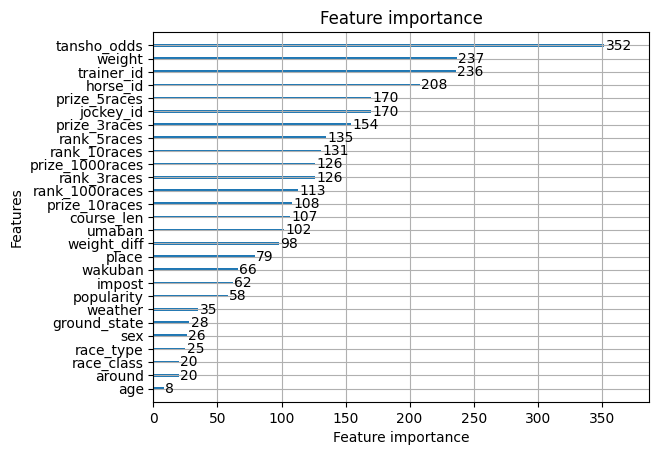

In [18]:
lgb.plot_importance(model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

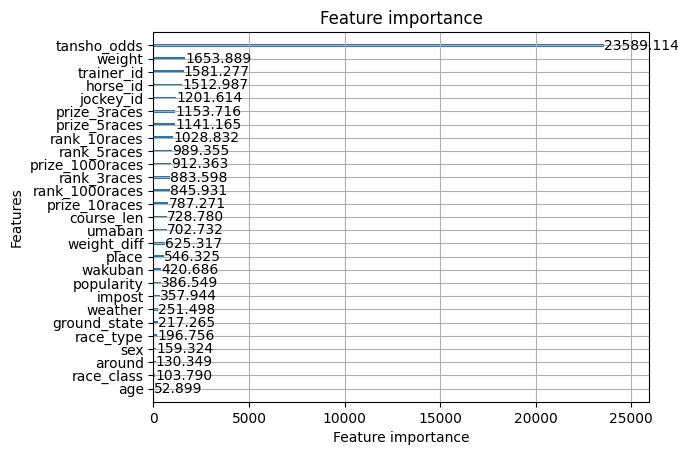

In [19]:
lgb.plot_importance(model, importance_type="gain")

# 予測処理